In [1]:
import os

import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic

from pyia import GaiaData

In [2]:
run_name = '150pc_MG12-result'
t = at.Table.read(f'../cache/probs-{run_name}.fits')
d = at.Table.read(f'../data/{run_name}.fits.gz')
joined = at.join(d, t, keys='source_id', join_type='left')

g = GaiaData(joined[joined['prob'] > 0.5])
ruwe = g.get_ruwe()

In [3]:
c = g.get_skycoord()

In [103]:
clean_g = g[(g.prob > 0.8) & (ruwe < 1.4) & (g.bp_rp < 1.6*u.mag)]

/mnt/home/apricewhelan/.local/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


# APOGEE

In [28]:
allstar = at.Table.read(os.path.expanduser('~/data/APOGEE_beta/allStar-r13-l33-58932beta.fits'))

In [104]:
np.isin(clean_g.source_id, allstar['GAIA_SOURCE_ID']).sum()

11

In [105]:
apogee_stars = allstar[np.isin(allstar['GAIA_SOURCE_ID'], clean_g.source_id)]
apogee_stars = apogee_stars[np.unique(apogee_stars['APOGEE_ID'], return_index=True)[1]]

In [106]:
xx = np.percentile(clean_g.phot_g_mean_mag.value, [5, 95])
tmp = ((allstar['GAIA_PARALLAX'] > coord.Distance(150*u.pc).parallax.value) &
       (allstar['GAIA_PHOT_G_MEAN_MAG'] > xx[0]) & 
       (allstar['GAIA_PHOT_G_MEAN_MAG'] < xx[1]) & 
       (allstar['LOGG'] > 3.5) & 
       (allstar['TEFF'] > 3500) & (allstar['TEFF'] < 6000))
allvsini = allstar['VSINI'][tmp]

Text(0.5, 1.0, 'HPW 1')

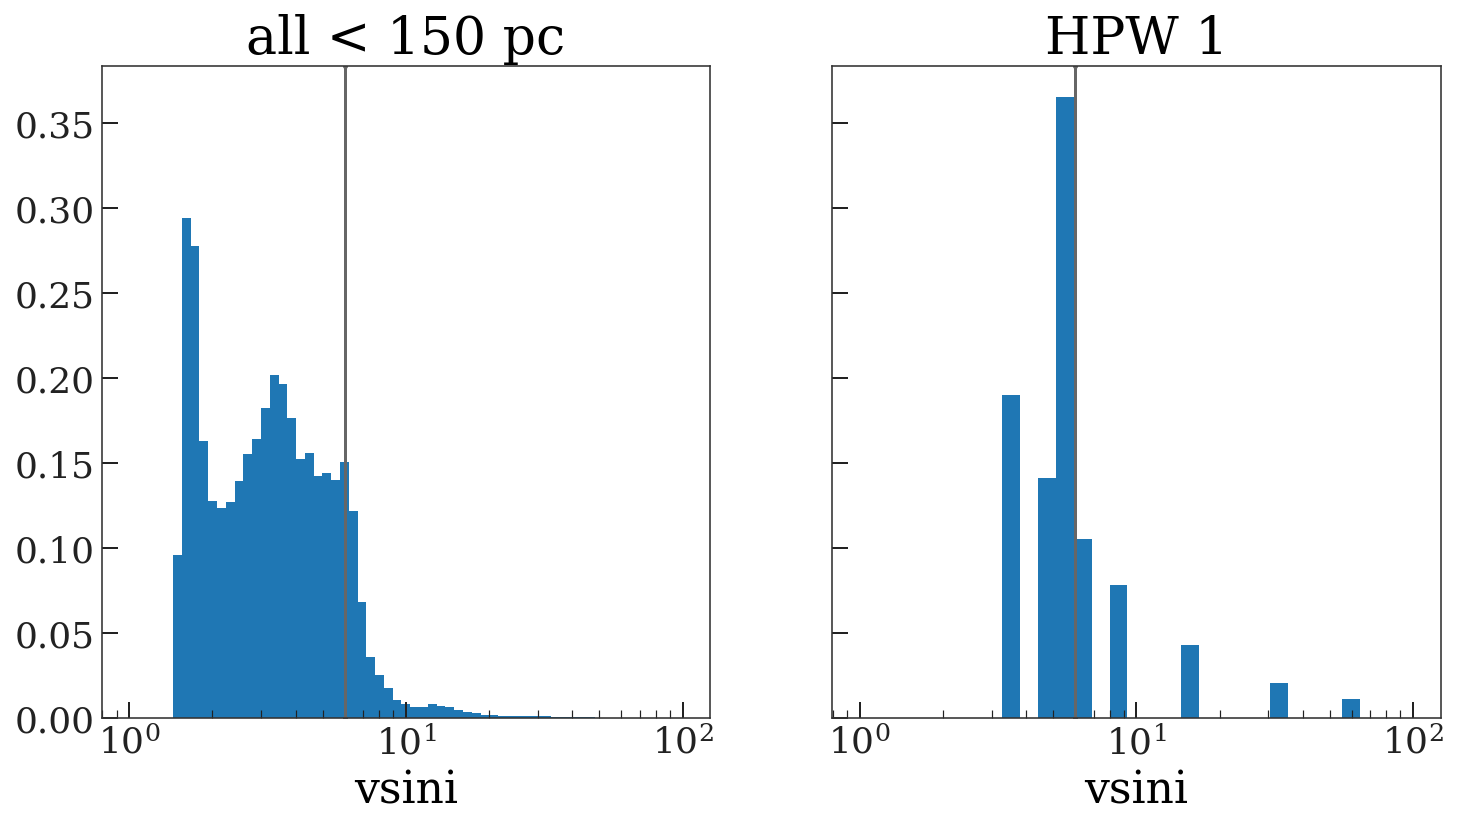

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6),
                         sharex=True, sharey=True)
axes[0].hist(allvsini, bins=np.logspace(0, 2, 64), density=True, color='tab:blue');
axes[1].hist(apogee_stars['VSINI'], bins=np.logspace(0, 2, 32), density=True, color='tab:blue');
axes[0].set_xscale('log')

for ax in axes:
    ax.set_xlabel('vsini')
    ax.axvline(6.)
    
axes[0].set_title('all < 150 pc')
axes[1].set_title('HPW 1')

In [73]:
(1*u.Rsun / (6*u.km/u.s)).to(u.day)

<Quantity 1.34201389 d>

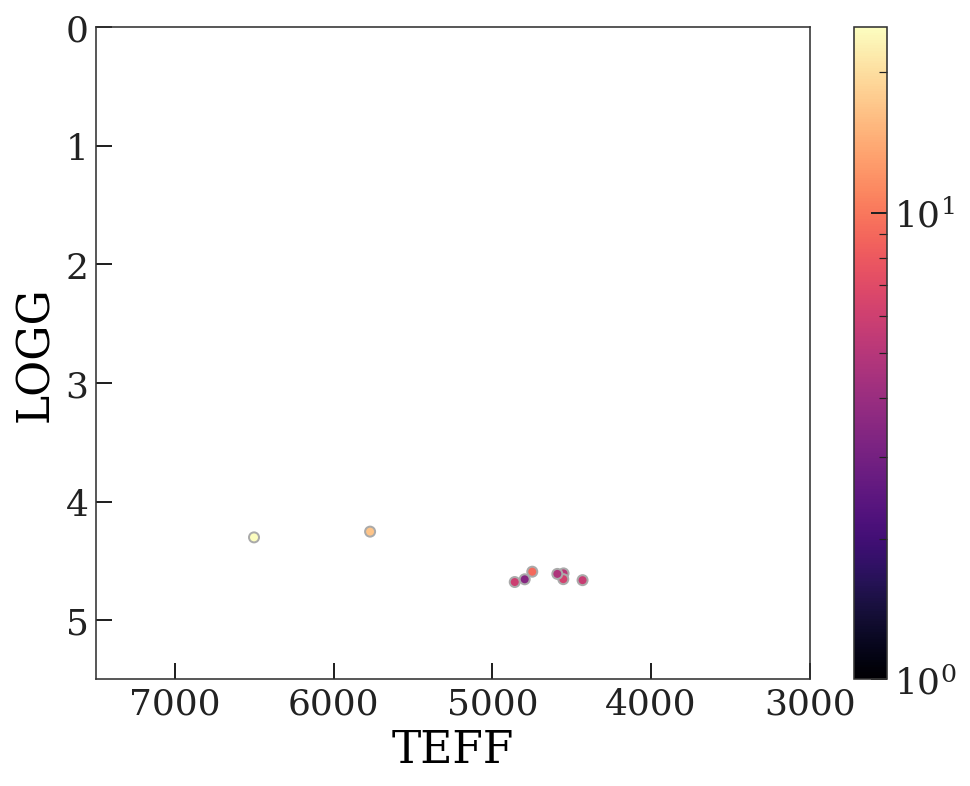

In [108]:
plt.figure(figsize=(8, 6))
plt.scatter(apogee_stars['TEFF'], apogee_stars['LOGG'], 
            c=apogee_stars['VSINI'], 
            norm=mpl.colors.LogNorm(1, 25),
            linewidth=1, edgecolor='#aaaaaa')
plt.xlim(7500, 3000)
plt.ylim(5.5, 0)
plt.xlabel('TEFF')
plt.ylabel('LOGG')
plt.colorbar()

In [86]:
orion_mask = np.array(['ORION' in x for x in allstar['FIELD']])
orion_mask &= (allstar['VHELIO_AVG'] > 20) & (allstar['VHELIO_AVG'] < 32)
orion_mask &= (allstar['LOGG'] > 3.5) & (allstar['TEFF'] > 3500) & (allstar['TEFF'] < 6500)
orion_mask.sum()

1435

(5.5, 0.0)

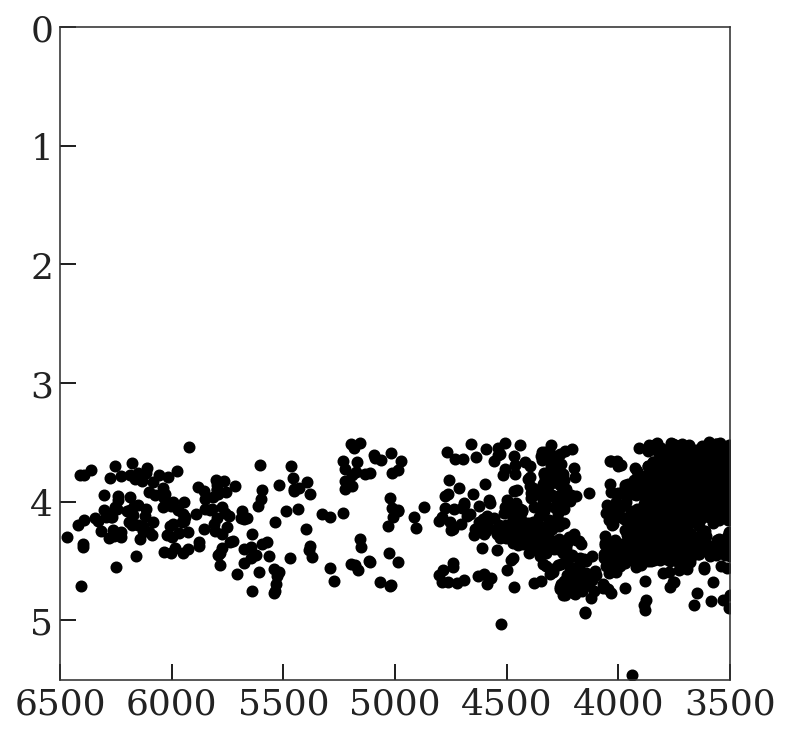

In [94]:
plt.scatter(allstar['TEFF'][orion_mask],
            allstar['LOGG'][orion_mask])
plt.xlim(6500, 3500)
plt.ylim(5.5, 0)

Text(0, 0.5, 'Mg/Fe')

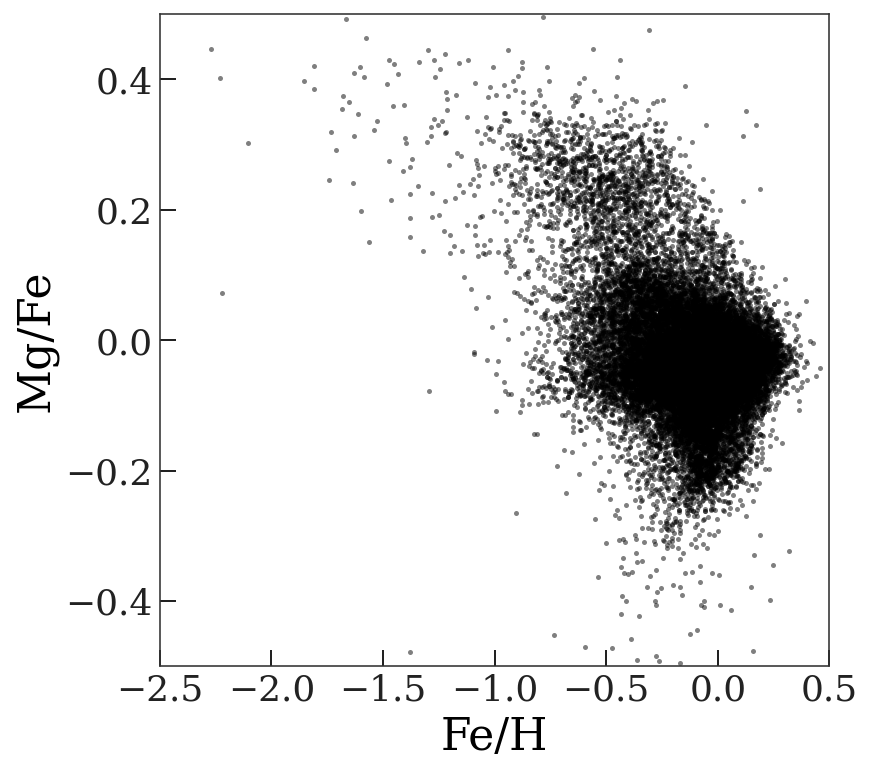

In [101]:
plt.errorbar(allstar['FE_H'][tmp],#[::300],
             allstar['MG_FE'][tmp],#[::300], 
             lw=0, alpha=0.5, ls='none')
plt.xlim(-2.5, 0.5)
plt.ylim(-0.5, 0.5)
plt.xlabel('Fe/H')
plt.ylabel('Mg/Fe')

Text(0, 0.5, 'Mg/Fe')

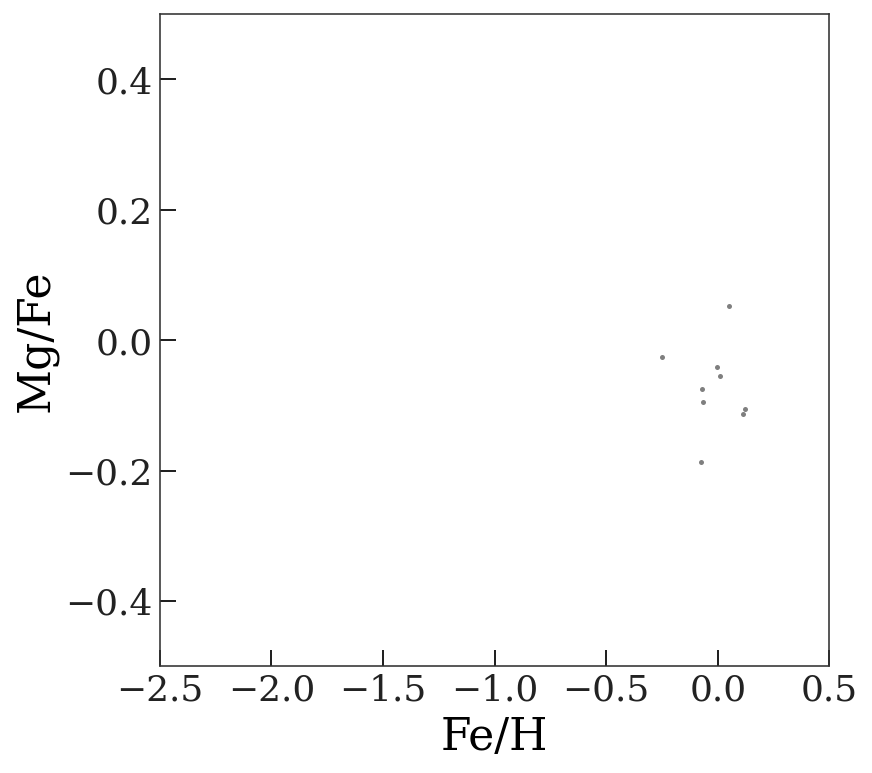

In [109]:
plt.errorbar(apogee_stars['FE_H'],
             apogee_stars['MG_FE'], 
             xerr=apogee_stars['FE_H_ERR'],
             yerr=apogee_stars['MG_FE_ERR'],
             lw=0, alpha=0.5, ls='none')
plt.xlim(-2.5, 0.5)
plt.ylim(-0.5, 0.5)
plt.xlabel('Fe/H')
plt.ylabel('Mg/Fe')

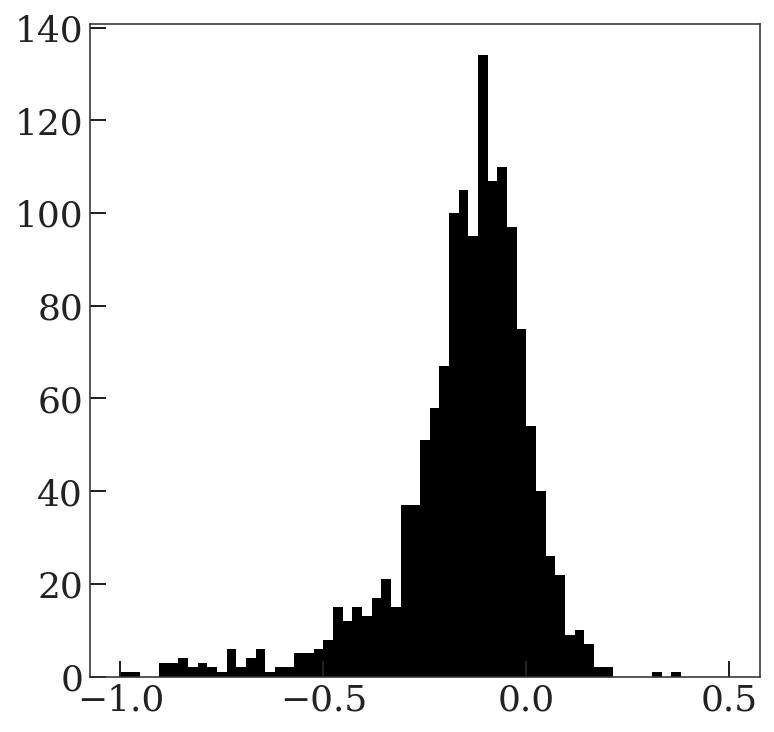

In [90]:
plt.hist(allstar['FE_H'][orion_mask], bins=np.linspace(-1, 0.5, 64));

In [91]:
std = 1.5 * np.median(np.abs(allstar['FE_H'][orion_mask] - np.median(allstar['FE_H'][orion_mask])))
std

0.12078982964158058

In [92]:
std = 1.5 * np.median(np.abs(apogee_stars['FE_H'] - np.median(apogee_stars['FE_H'])))
std

0.21670496463775635

Text(0, 0.5, 'Mg/Fe')

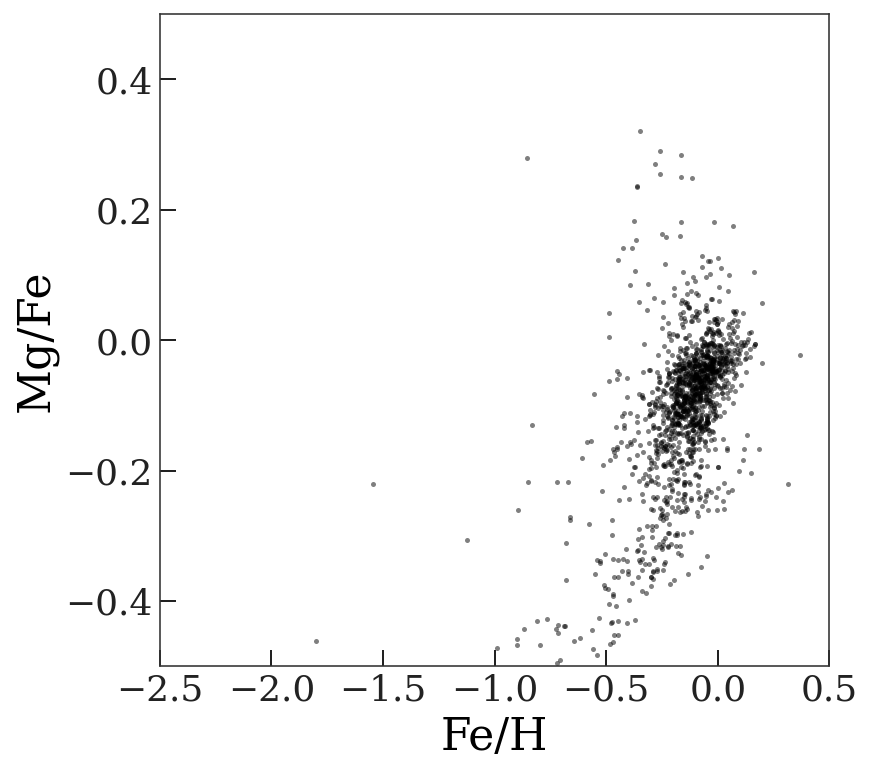

In [88]:
plt.errorbar(allstar['FE_H'][orion_mask],
             allstar['MG_FE'][orion_mask],
#              xerr=apogee_stars['FE_H_ERR'],
#              yerr=apogee_stars['MG_FE_ERR'],
             lw=0, alpha=0.5, ls='none')
plt.xlim(-2.5, 0.5)
plt.ylim(-0.5, 0.5)
plt.xlabel('Fe/H')
plt.ylabel('Mg/Fe')

(-0.5, 0.5)

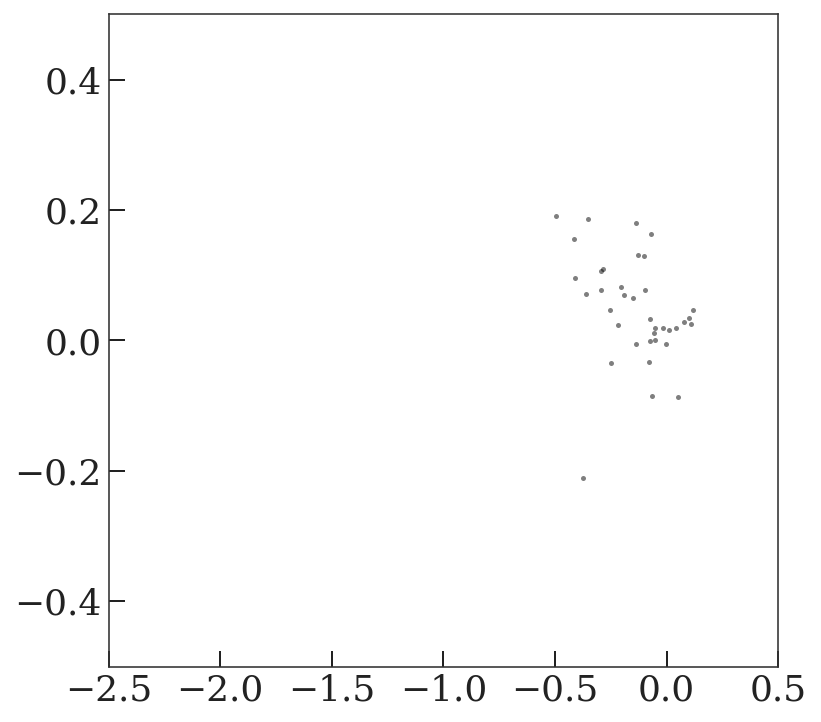

In [47]:
plt.errorbar(apogee_stars['FE_H'],
             apogee_stars['CA_FE'], 
             xerr=apogee_stars['FE_H_ERR'],
             yerr=apogee_stars['CA_FE_ERR'],
             lw=0, alpha=0.5, ls='none')
plt.xlim(-2.5, 0.5)
plt.ylim(-0.5, 0.5)